## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Основная идея:
###### объединить метод Главных Компанент (ГК)  и Гистограммы Градиентов (ГГ), и подать все это на вход в классификатор случайного леса.

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./test.csv', delimiter=',', skiprows=1)

## PCA (ГК)

In [24]:
train_pca=train[:, 1:]
test_pca=test
# Нормировка
scaler = StandardScaler()
scaler.fit(train_pca)
train_pca = scaler.transform(train_pca)
test_pca = scaler.transform(test_pca)
# Выделение ГК
pca = PCA(.75)
pca.fit(train_pca)
train_pca=pca.transform(train_pca)
test_pca=pca.transform(test_pca)

In [25]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

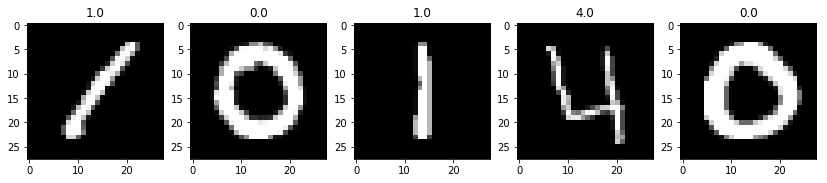

In [26]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [27]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [28]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [29]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [30]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

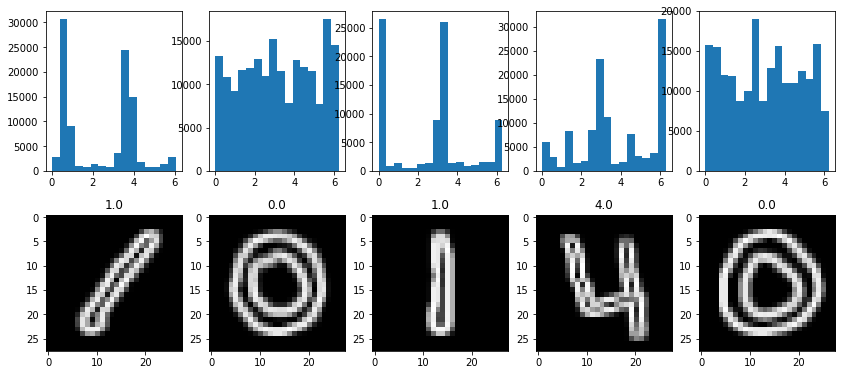

In [31]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [32]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [33]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [34]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [35]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Объединение ГГ и ГК

In [36]:
train_hist_pca=np.concatenate((train_hist, train_pca), axis=1)
test_hist_pca=np.concatenate((test_hist, test_pca), axis=1)

## Разбиваем выборку на обучение и валидацию

In [37]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist_pca, test_size=0.2,
    random_state=42)

## Случайный лес

In [46]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, max_depth=7,random_state=0)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [47]:
from sklearn.metrics import accuracy_score
pred_val=clf.predict(x_val)
print('Accuracy: %s' % accuracy_score(y_val, pred_val).round(4))

Accuracy: 0.9001


In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       816
         1.0       0.99      0.99      0.99       909
         2.0       0.87      0.88      0.88       846
         3.0       0.81      0.90      0.86       937
         4.0       0.94      0.90      0.92       839
         5.0       0.88      0.83      0.85       702
         6.0       0.91      0.94      0.92       785
         7.0       0.95      0.89      0.92       893
         8.0       0.87      0.81      0.84       835
         9.0       0.84      0.88      0.86       838

   micro avg       0.90      0.90      0.90      8400
   macro avg       0.90      0.90      0.90      8400
weighted avg       0.90      0.90      0.90      8400



In [49]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[784   1   3   0   2   2  14   1   6   3]
 [  0 897   3   1   0   0   4   1   1   2]
 [ 10   0 745  31   1   9  21   2  22   5]
 [  1   0  22 845   0  17   2   3  34  13]
 [  2   1   7   1 759   0  17   3   2  47]
 [  4   0  15  78   2 580  10   2   9   2]
 [ 12   1  10   1   5   7 739   0  10   0]
 [  0   1  12   9  10  11   1 794   6  49]
 [  5   3  25  58   7  29   7   1 680  20]
 [  9   2  13  13  18   3   0  33   9 738]]


##### Теперь обучим на всем трайне случайный лес и проверим себя на изображениях из теста

In [50]:
clf.fit(train_hist_pca, train_label)
pred_test=clf.predict(test_hist_pca)

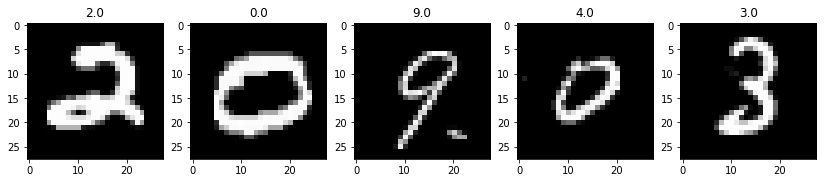

In [51]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [52]:
with open('result.csv','w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
!print submit.txt